# Debuggin NMF

In [9]:
# imports
import os
import numpy as np

import torch
import h5py

from matplotlib import pyplot as plt

from ihop.emulators import nn
from ihop.emulators.nn import SimpleNet, DenseNet
from ihop.emulators import io
from ihop.iops.nmf import load_loisel_2023
from ihop.emulators import io as ihop_io
from ihop.iops import nmf as ihop_nmf

In [10]:
%matplotlib ipympl

# Load 

In [12]:
#def load_up(in_idx:int, chop_burn = -3000,
#            iop_type:str='nmf'):

in_idx = 0
chop_burn = -3000
iop_type = 'nmf'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Chains
out_path = os.path.join(
    os.getenv('OS_COLOR'), 'IHOP', 'L23',
    iop_type.upper())
chain_file = 'fit_a_L23_NN_Rs10.npz'
       
# Load prep
if iop_type == 'pca':
    lfunc = load_loisel_2023_pca
    em_path = os.path.join(os.getenv('OS_COLOR'), 'IHOP', 
                           'Emulators', 'SimpleNet_PCA')
    model_file += '/model_100000.pth'
    ncomp = 3
elif iop_type == 'nmf':
    # Model
    em_path = os.path.join(os.getenv('OS_COLOR'), 'IHOP', 
                           'Emulators')
    model_file = os.path.join(
        em_path, 'DenseNet_NM4',
        'densenet_NMF_[512, 512, 512, 256]_epochs_2500_p_0.0_lr_0.01.pth')
    lfunc = load_loisel_2023
    ncomp = 4

# Do it
print("Loading Hydrolight data")
ab, Rs, d_a, d_bb = lfunc()
print(f"Loading model: {model_file}")
model = ihop_io.load_nn(model_file)

nwave = d_a['wave'].size

# MCMC
print("Loading MCMC")
d = np.load(os.path.join(out_path, chain_file))
chains = d['chains']
l23_idx = d['idx']
obs_Rs = d['obs_Rs']

idx = l23_idx[in_idx]
print(f'Working on: L23 index={idx}')

# Prep
if iop_type == 'pca':
    rfunc = ihop_pca.reconstruct
    wave = d_a['wavelength']
elif iop_type == 'nmf':
    rfunc = ihop_nmf.reconstruct
    wave = d_a['wave']

# a
Y = chains[in_idx, chop_burn:, :, 0:ncomp].reshape(-1,ncomp)
orig, a_recon = rfunc(Y, d_a, idx)
a_mean = np.mean(a_recon, axis=0)
a_std = np.std(a_recon, axis=0)
_, a_pca = rfunc(ab[idx][:ncomp], d_a, idx)

print("All loaded")

Loading Hydrolight data
Loading model: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/DenseNet_NM4/densenet_NMF_[512, 512, 512, 256]_epochs_2500_p_0.0_lr_0.01.pth
Loading MCMC
Working on: L23 index=2554
All loaded


In [13]:
a_pca.shape

(71,)

# Straight NMF

## Load

In [20]:
nmf_file = '/home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/L23_NMF_a_4.npz'

In [21]:
nmf = np.load(nmf_file)
list(nmf.keys())

['M', 'coeff', 'spec', 'mask', 'err', 'wave', 'Rs']

In [18]:
ab[idx], ncomp

(array([3.46182106e-03, 2.48177440e-03, 1.53537630e-02, 3.66354873e-02,
        2.20975756e-06, 3.55264507e-06, 4.11508578e-05, 4.09850767e-03]),
 4)

In [22]:
idx

2554

In [19]:
Y[idx,0:ncomp]

array([0.01424113, 0.00114554, 0.10619046, 0.06460544])

## True

In [29]:
nmf_true = np.dot(nmf['coeff'][idx], nmf['M'])

In [28]:
nmf['M'].shape

(4, 71)

# Plot

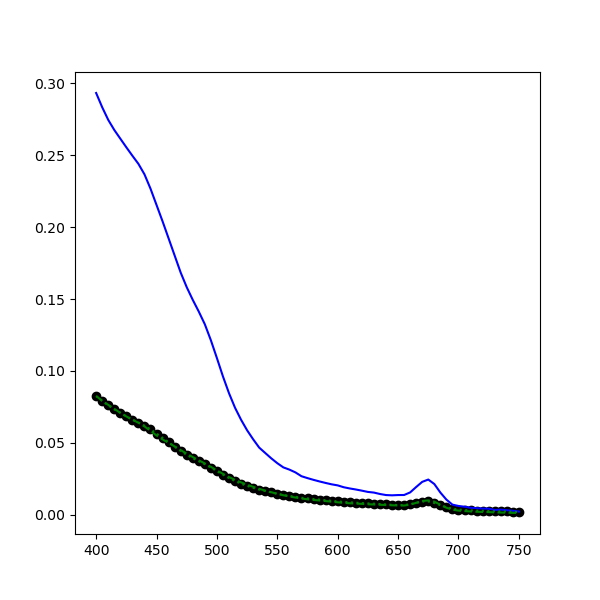

In [30]:
fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()

#
ax.plot(wave, orig, 'ko', label='True')
ax.plot(wave, a_recon[idx], 'b-', label='Fit')
#
ax.plot(wave, nmf['spec'][idx], 'g:')
ax.plot(wave, nmf_true, 'g--', label='True NMF')

plt.show()